In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import glob
from statsmodels.graphics.gofplots import qqplot
from numpy.random import seed
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import plotly.express as px


## Functıons 

In [60]:
pd.options.plotting.backend="plotly"

In [61]:
# Function to extract float values from a string in the format "[x,y,z]"
def get_float_values(string):
    value_str = string.split('[')[1].split(']')[0].split(",")[0]
    if value_str.strip() == '':
        return None  # Return None for empty values or you can use any other default value
    return float(value_str)

# Function to analyze response times data and calculate various statistics
def analyze_response_times(df,false_alarm_threshold=100, miss_threshold=1000):
    
    # Extract float values from the 'Response Times' column of the DataFrame
    aPVT = [get_float_values(string) for string in df['Response Times'].values]
    
    df['Classification'] = 'Hit'  # Assume all trials are hits by default

    for i, response_times in enumerate(aPVT):
        if response_times is None:
            df.at[i, 'Classification'] = 'Lapse'
        elif isinstance(response_times, list) and len(response_times) > 1:
            df.at[i, 'Classification'] = 'False Alarm'
            print(df['Response Times'].values[i])
            print(aPVT[i])
        else:
            rt = response_times
            if rt < false_alarm_threshold:
                df.at[i, 'Classification'] = 'False Alarm'
                print('at rt: ', df['Response Times'].values[i])
                print(aPVT[i])
            elif rt > miss_threshold:
                df.at[i, 'Classification'] = 'Miss'
                print('Miss at rt: ', df['Response Times'].values[i])
                print(aPVT[i])
    # Convert the 'Timestamp' column to datetime objects if it's not already
    df['Timestamps'] = pd.to_datetime(df['Timestamps'])

    # Calculate time elapsed in minutes and store it in a new column 'TimeMinutes'
    df['TimeMinutes'] = (df['Timestamps'] - df['Timestamps'].iloc[0]).dt.total_seconds() / 60.0



    # Filter out false alarms and misses from the 'aPVT' list
    correct_responses = [rt for rt in aPVT if isinstance(rt, float) and false_alarm_threshold <= rt <= miss_threshold]

    # Calculate mean, median, and standard deviation of response times
    mean_rt = np.mean(correct_responses)
    median_rt = np.median(correct_responses)
    std_rt = np.std(correct_responses)
    
    # Calculate effective size (eff_size) using a fixed value of 4
    eff_size = (mean_rt - 4) / std_rt
    eff_size_median = (median_rt - 4) / std_rt
    
    # Sort reaction times in ascending order
    sorted_reaction_times = sorted(correct_responses)
    
    # Calculate the number of elements to take from the sorted list (10% of total elements)
    n = round(len(sorted_reaction_times) * 0.1)
    
    # Get the fastest 10% of reaction times
    fastest_10_percent = sorted_reaction_times[:n]
    
    # Convert reaction times to 1000 divided by each value, then sort in ascending order
    aPVT_1000 = [1000 / value for value in aPVT]
    sorted_reaction_times_1000 = sorted(aPVT_1000)
    
      
    # Get the slowest 10% of reaction times (slowest in terms of 1000 divided by each value)
    slowest_10_percent = sorted_reaction_times_1000[:n]
    
    # Convert the values back to actual reaction times by dividing 1000 by each value
    actual_slowest = [int(1000 / i) for i in slowest_10_percent]
    
    # Return all calculated statistics and lists of fastest and slowest reaction times
    return mean_rt, median_rt, std_rt, eff_size, fastest_10_percent, actual_slowest

# Function to count "false alarms" in the DataFrame based on the length of the 'Response Times' column


# Main function to process data from CSV files
def processData(filename, condition="Light"):
    # Initialize lists to store calculated statistics
    mean_00_10_aPVT = []
    median_00_10_aPVT = []
    std_00_10_aPVT = []
    eff_size_00_10_aPVT = []
    lapses = []
    alarms = []
    
    # Loop through the CSV files matching the given pattern
    for i, name in enumerate(glob.glob(filename, recursive=True)): 
        # Read data from the CSV file into a DataFrame
        df = pd.read_csv(name)
                
        # Count the number of rows where 'Response Times' column is empty and store the count in the 'lapses' list
        lapse = (df.values.ravel() == '[]').sum() 
        lapses.append(lapse)
        
        # Remove rows with empty 'Response Times' and reset the DataFrame index
        df = df[~(df == '[]').any(axis=1)]
        df.reset_index(drop=True, inplace=True)

        # Analyze the response times in the DataFrame and store the statistics in the respective lists
        mean_aPVT, median_aPVT, std_aPVT, eff_size_aPVT, fastest_10_percent, slowest_10_percent = analyze_response_times(df)

        mean_00_10_aPVT.append(mean_aPVT)
        median_00_10_aPVT.append(median_aPVT)
        std_00_10_aPVT.append(std_aPVT)
        eff_size_00_10_aPVT.append(eff_size_aPVT)

    # Calculate the general mean of mean_00_10_aPVT list
    general_mean = np.mean(mean_00_10_aPVT)

    # Plot the mean response time for the 'condition'
    #myplot(data=mean_00_10_aPVT, condition=condition)
    
    # Read data from CSV files and store it in a list of DataFrames
    data_frames = []
    for i, name in enumerate(glob.glob(filename, recursive=True)): 
        df = pd.read_csv(name)
        data_frames.append(df)
    
    return mean_00_10_aPVT, median_00_10_aPVT, std_00_10_aPVT, eff_size_00_10_aPVT, data_frames



In [82]:

filename = "./aPVT_lightCondition/*.csv"
lc_data_mean, lc_data_median, lc_data_std, lc_mean_eff_size, data_frames = processData(filename)

light_data = {
    ('Light condition', 'Mean'): lc_data_mean,
    ('Light condition', 'Median'): lc_data_median,
    ('Light condition', 'Standard Deviation'): lc_data_std,
    ('Light condition', 'Effective Size'): lc_mean_eff_size,
}

df1 = pd.DataFrame(light_data)
print(df1)


   Light condition                                         
              Mean Median Standard Deviation Effective Size
0       243.025641  238.0          61.195981       3.905904
1       312.540541  307.0          23.652432      13.044770
2       321.514286  321.0          23.201443      13.685110
3       338.542857  336.0          34.491691       9.699230
4       348.028571  343.0          28.497103      12.072405
5       342.384615  344.0          30.710906      11.018386
6       349.032258  337.0          35.302823       9.773503
7       352.048780  339.0          51.692313       6.733086
8       369.472222  347.5          73.798331       4.952310
9       358.800000  350.0          35.664949       9.948143
10      356.941176  350.5          38.188342       9.242118


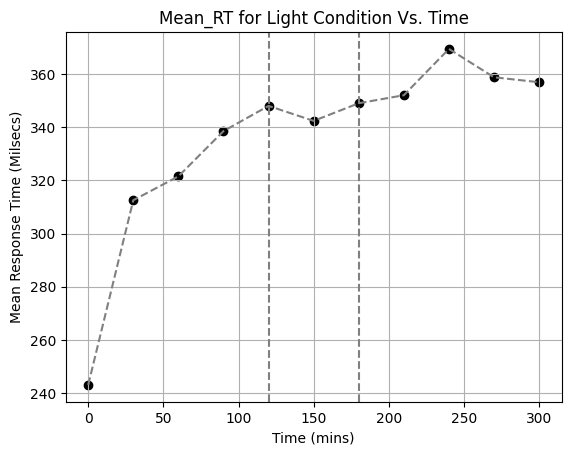

In [83]:
#  plot
#time = [i for i in range(11)]
time = [0,30,60,90,120,150,180,210,240,270,300]

# Define the x-coordinates for the vertical lines
vertical_lines = [120, 180]

# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')

#Light condition
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')
plt.plot(time, lc_data_mean, color='grey', linestyle='--')
plt.scatter(time, lc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Light Condition Vs. Time')
plt.grid()
plt.show()


In [64]:
df1.to_csv('lightCondition.csv', index=False)

In [84]:
filename = "./aPVT_darkCondition/*.csv"
dc_data_mean, dc_data_median, dc_data_std, dc_data_eff_size, data_frames = processData(filename, condition = "Dark")

dark_data = {
    ('Dark  condition', 'Mean'): dc_data_mean,
    ('Dark  condition', 'Median'): dc_data_median,
    ('Dark  condition', 'Standard Deviation'): dc_data_std,
    ('Dark  condition', 'Effective Size'): dc_data_eff_size
}

df2 = pd.DataFrame(dark_data)
print(df2)

   Dark  condition                                         
              Mean Median Standard Deviation Effective Size
0       236.051282  226.0          36.899690       6.288705
1       248.882353  248.0          22.513741      10.877018
2       258.972222  255.0          51.068846       4.992716
3       267.916667  270.0          26.228033      10.062389
4       273.081081  272.0          35.773596       7.521779
5       281.028571  280.0          28.430854       9.743941
6       311.818182  303.0          52.686871       5.842408
7       325.108108  312.0          52.511921       6.114956
8       331.882353  311.5          74.579119       4.396436
9       274.555556  273.0          26.927314      10.047625
10      316.973684  311.5          64.909446       4.821697


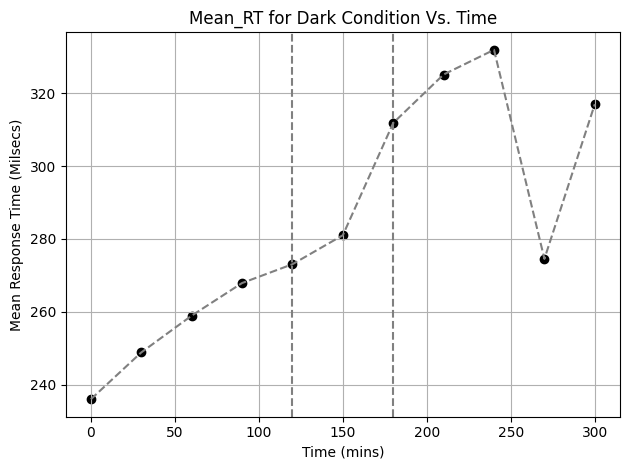

In [85]:
# Define the x-coordinates for the vertical lines
vertical_lines = [120, 180]

# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')
#Dark condition
#plt.style.use('fivethirtyeight')
plt.plot(time, dc_data_mean, color='grey', linestyle='--')
plt.scatter(time, dc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Dark Condition Vs. Time')
plt.grid()
plt.tight_layout()
plt.show()


In [86]:
ReactionT_Result = pd.merge(df1, df2, left_index=True, right_index=True)
ReactionT_Result

Light condition                                          Dark  condition  \
              Mean Median Standard Deviation Effective Size            Mean   
0       243.025641  238.0          61.195981       3.905904      236.051282   
1       312.540541  307.0          23.652432      13.044770      248.882353   
2       321.514286  321.0          23.201443      13.685110      258.972222   
3       338.542857  336.0          34.491691       9.699230      267.916667   
4       348.028571  343.0          28.497103      12.072405      273.081081   
5       342.384615  344.0          30.710906      11.018386      281.028571   
6       349.032258  337.0          35.302823       9.773503      311.818182   
7       352.048780  339.0          51.692313       6.733086      325.108108   
8       369.472222  347.5          73.798331       4.952310      331.882353   
9       358.800000  350.0          35.664949       9.948143      274.555556   
10      356.941176  350.5          38.188342       9.242118      316.973684   

                                             
   Median Standard Deviation Effective Size  
0   226.0          36.899690       6.288705  
1   248.0          22.513741      10.877018  
2   255.0          51.068846       4.992716  
3   270.0          26.228033      10.062389  
4   272.0          35.773596       7.521779  
5   280.0          28.430854       9.743941  
6   303.0          52.686871       5.842408  
7   312.0          52.511921       6.114956  
8   311.5          74.579119       4.396436  
9   273.0          26.927314      10.047625  
10  311.5          64.909446       4.821697

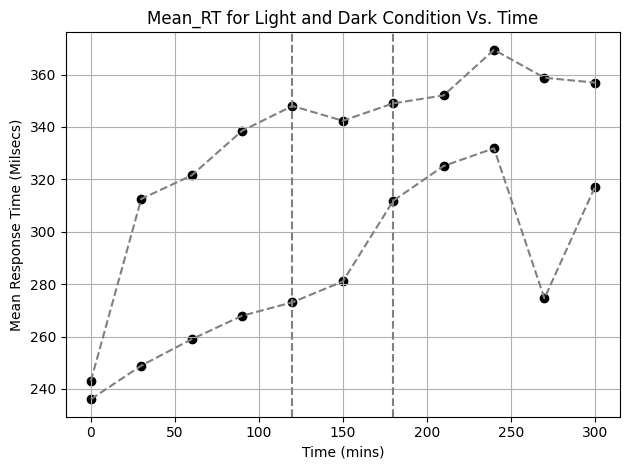

In [87]:

#Light condition
# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')
#Dark condition
#plt.style.use('ggplot')
plt.plot(time, dc_data_mean, color='grey', linestyle='--')
plt.scatter(time, dc_data_mean, color='black', label='Points')
plt.plot(time, lc_data_mean, color='grey', linestyle='--')
plt.scatter(time, lc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Light and Dark Condition Vs. Time')
plt.grid()
plt.tight_layout()
plt.show()

In [69]:
#myplot(data = lc_data_mean,data2 = dc_data_mean, condition = "Light and Dark",_range = 11,combine_plot = True)

## Normality Test using Hist, Boxplot, and Shapiro Wilk Test

{'whiskers': [<matplotlib.lines.Line2D at 0x1e798449750>,
 'caps': [<matplotlib.lines.Line2D at 0x1e798448100>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e79844b5e0>,
 'medians': [<matplotlib.lines.Line2D at 0x1e7984483a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e7984490c0>,
 'means': []}

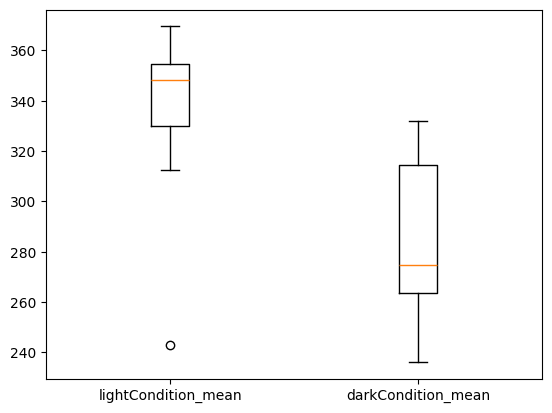

In [70]:
plt.boxplot([lc_data_mean,dc_data_mean], labels = ['lightCondition_mean', 'darkCondition_mean'])

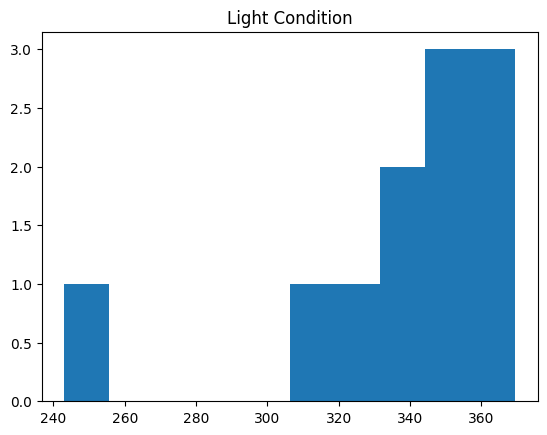

In [71]:
lc_data_mean = pd.DataFrame(lc_data_mean)
plt.hist(lc_data_mean)
plt.title('Light Condition')
plt.show()

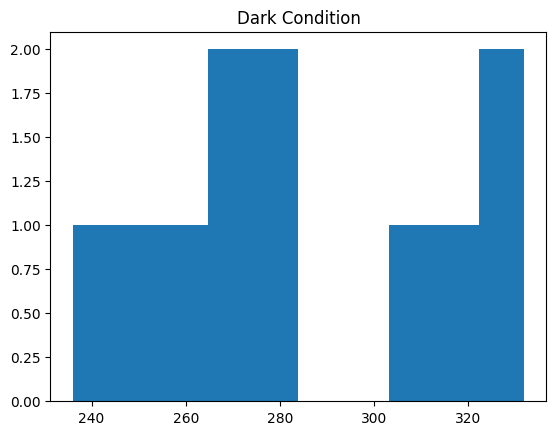

In [72]:
dc_data_mean = pd.DataFrame(dc_data_mean)
plt.hist(dc_data_mean)
plt.title('Dark Condition')
plt.show()

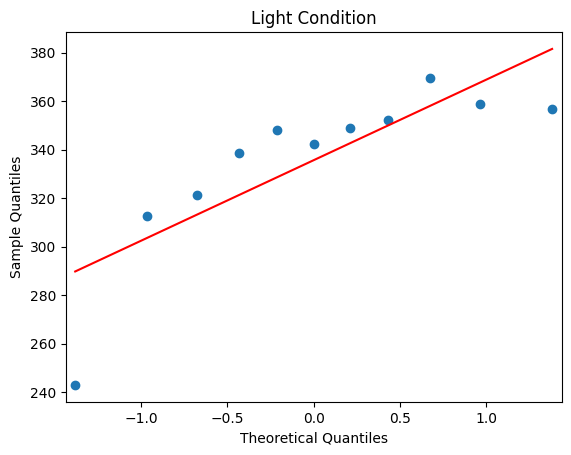

In [73]:
qqplot(lc_data_mean, line = 's')
plt.title('Light Condition')
plt.show()

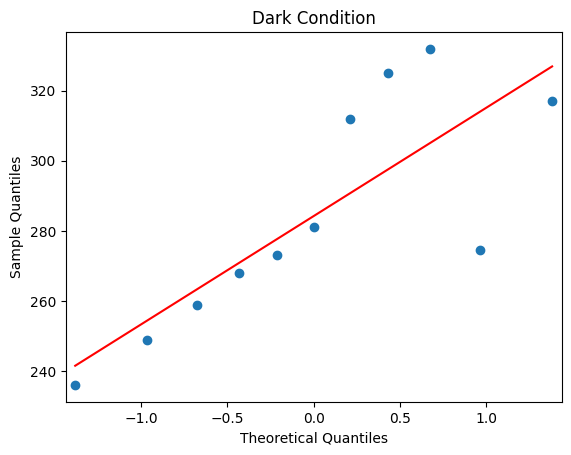

In [74]:
dc_data_mean = np.array(dc_data_mean)
qqplot(dc_data_mean, line = 's')
plt.title('Dark Condition')
plt.show()

In [75]:
#Normality test using Shapiro-Wilk Test for Light Condition
#normality Test
stat, p = shapiro(lc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
        

Statistics = 0.770, p = 0.004
Sample does not look Gaussian (reject H0)


In [76]:
#Normality test using Shapiro-Wilk Test for Dark Condition
#normality Test
stat, p = shapiro(dc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
        

Statistics = 0.933, p = 0.446
Sample looks Gaussian (fail to reject H0)


In [81]:
#After carrying out the normality test, the results showed that, the data
#are not normal; hence non-parametric test has to be done.

#Since the dark condition and light condition are independent, Mann Whitney U test is performed.
#Normality test using Shapiro-Wilk Test for Dark Condition
#normality Test
stat, p = mannwhitneyu(lc_data_mean,dc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics = 106.000, p = 0.003
Sample does not look Gaussian (reject H0)


C:\Users\ysogodok\AppData\Local\Temp\ipykernel_9752\3854971395.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Statistics = %.3f, p = %.3f' % (stat, p))
